## HW3: Decision Tree and Random Forest
In hw3, you need to implement decision tree and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

In [302]:
!pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1320 sha256=2ed4171e6f74680e268ca4c27a1f0b9ba6c3bc5d2f82b487f82a9fe135ef9952
  Stored in directory: c:\users\hp 15\appdata\local\pip\cache\wheels\46\ef\c3\157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


## Load data

In [42]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
import math
from fractions import Fraction
import matplotlib.pyplot as plt
import random

In [43]:
data = load_breast_cancer()
feature_names = data['feature_names']
print(feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [44]:
x_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
x_test = pd.read_csv("x_test.csv")
y_test = pd.read_csv("y_test.csv")

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 7 of hw3 slides](https://docs.google.com/presentation/d/1ish3jEr_6be0FK4kgOZa12nYAyJFh0P2LCNsNPOCiXo/edit#slide=id.g7703d1636d_0_21)

In [45]:
def gini(sequence):
    answer = 1
    num_c1 = 0
    num_c2 = 0
    for x in sequence:
        if x == 1:
            num_c1 += 1
        else:
            num_c2 += 1
    answer = 1 - (num_c1 / sequence.size) ** 2 - (num_c2 / sequence.size) ** 2
    return answer


def entropy(sequence):
    answer = 1
    num_c1 = 0
    num_c2 = 0
    for x in sequence:
        if x == 1:
            num_c1 += 1
        else:
            num_c2 += 1
    p1 = num_c1 / sequence.size
    p2 = num_c2 / sequence.size
    if p1 == 0 or p2 == 0:
        answer = 0
    else:
        answer = p1 * math.log2(p1) + p2 * math.log2(p2)
    answer = -answer
    return answer

In [46]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [47]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [48]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006402


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **Criterion**: The function to measure the quality of a split. Your model should support “gini” for the Gini impurity and “entropy” for the information gain. 
2. **Max_depth**: The maximum depth of the tree. If Max_depth=None, then nodes are expanded until all leaves are pure. Max_depth=1 equals to split data once


In [49]:
y_ = y_train.squeeze()
print(y_.shape)
x_train_copy = x_train.values[:, :] #將Dataframe 轉成 ndarray

(426,)


In [50]:
class Node():
    def __init__(self, criterion, num_samples, num_samples_per_class, predicted):
        self.left = None
        self.right = None
        self.criterion = criterion
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted = predicted
        self.feature_index = 0
        self.threshold = 0

In [51]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, X=x_train_copy, idx=None, y=y_):
        self.criterion = criterion
        if max_depth is None:
            max_depth = 100
        self.max_depth = max_depth
        if idx is None:
            idx = [True for i in range(30)]
        self.idx = idx
        self.n_class = 2
        self.n_features = X.shape[1]
        self.feature_importance = np.zeros(self.n_features)
        self.root = self.GenerateTree(X, y, 0)
        

    def GenerateTree(self, X, y, depth):
        num_samples_per_class = [np.sum(y == i) for i in range(2)]    
        predicted = np.argmax(num_samples_per_class)   #取多數
        if self.criterion == 'gini':
            node = Node(
                gini(y),
                y.size,
                num_samples_per_class,
                predicted,
            )
        else:
            node = Node(
                entropy(y),
                y.size,
                num_samples_per_class,
                predicted,
            )
        if depth < self.max_depth and gini(y) > 0:   #判斷是否為leaf
            index, threshold = self.spliattri(X, y)
            if index is not None:   #判斷是否可以再分
                indices_left = X[:, index] < threshold
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = index
                self.feature_importance[index] += 1
                node.threshold = threshold
                node.left = self.GenerateTree(X_left, y_left, depth + 1)
                node.right = self.GenerateTree(X_right, y_right, depth + 1)
        return node
    
    
    def spliattri(self, X, y):
        best_idx, best_thre = None, None
        if y.size <= 1:
            return None, None
        n = y.size
        if self.criterion == 'gini':
            best_crit = gini(y)
        else:
            best_crit = entropy(y)
        num_parent = [np.sum(y == i) for i in range(2)]
        for i in range(self.n_features):
            if self.idx[i] is False:  #為了 Random forest
                continue
            new_ = zip(X[:, i], y)
            new_ = sorted(new_)
            threshold, classes = zip(*new_)
            # 先把threshold sort過可以讓之後每次分的時候只要O(1)
            num_left = [0, 0]
            num_right = num_parent.copy()
            # threshold從最小開始，所以num_left一開始是0，num_right和num_parent一樣
            for j in range(1, n):  #  0等於沒分不用考慮
                
                c = classes[j - 1]
                num_left[c] += 1
                num_right[c] -= 1
                if threshold[j] == threshold[j - 1]:
                    continue
                if self.criterion == 'gini': #PEP8一行有字數上限，所以分開寫
                    criterion_left = 1 
                    criterion_right = 1
                    for x in range(2):
                        p1 = num_left[x] / j
                        p2 = num_right[x] / (n - j)
                        criterion_left -= p1 ** 2
                        criterion_right -= p2 ** 2
                else:
                    criterion_left = 0  
                    criterion_right = 0
                    for x in range(2):
                        p1 = num_left[x] / j
                        p2 = num_right[x] / (n - j)
                        if p1 == 0:
                            criterion_left += 0
                        else:
                            criterion_left += p1 * math.log2(p1)
                        if p2 == 0:
                            criterion_right += 0
                        else:
                            criterion_right += p2 * math.log2(p2)
                    criterion_left = -criterion_left
                    criterion_right = -criterion_right
                crit = criterion_left * (j / n) + criterion_right * (n - j) / n
                if crit < best_crit:
                    best_crit = crit
                    best_idx = i
                    best_thre = (threshold[j] + threshold[j - 1]) / 2 # midpoint
        return best_idx, best_thre
    
    
    def predict(self, X, y):
        result = [self.predict_(i) for i in X]
        num_correct = 0
        num_incorrect = 0
        for i in range(y.size):
            if result[i] == y[i]:
                num_correct += 1
            else:
                num_incorrect += 1
        return num_correct / (num_correct + num_incorrect)
    
    
    def predict_(self, X):
        node = self.root
        while node.right:   #判斷是否為leaf
            if X[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted        

### Question 2.1
Using Criterion=‘gini’, showing the accuracy score of test data by Max_depth=3 and Max_depth=10, respectively.


In [52]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

In [53]:
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()
print("Accuracy % of clf_depth3 is {}".format(clf_depth3.predict(x_test, y_test)))
print("Accuracy % of clf_depth10 is {}".format(clf_depth10.predict(x_test, y_test)))

Accuracy % of clf_depth3 is 0.9230769230769231
Accuracy % of clf_depth10 is 0.916083916083916


### Question 2.2
Using Max_depth=3, showing the accuracy score of test data by Criterion=‘gini’ and Criterion=’entropy’, respectively.


In [54]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
print("Accuracy % of clf_gini  is {}".format(clf_gini.predict(x_test, y_test)))
print("Accuracy % of clf_entropy is {}".format(clf_entropy.predict(x_test, y_test)))

Accuracy % of clf_gini  is 0.9230769230769231
Accuracy % of clf_entropy is 0.9370629370629371


- Note: All of your accuracy scores should over 0.9
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the feature counts for building tree without normalize the importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

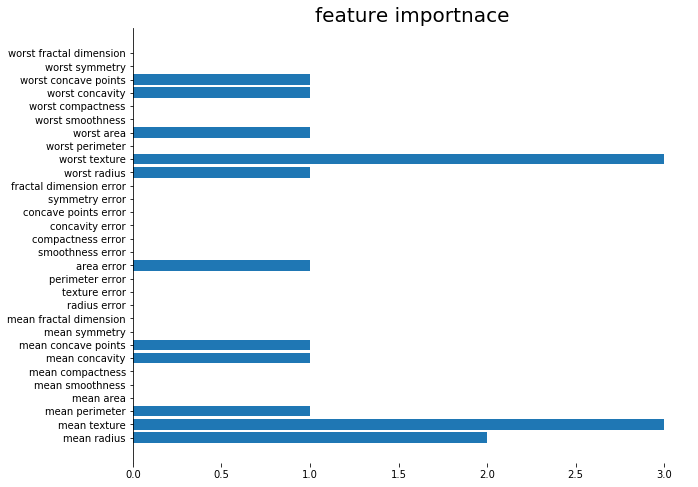

In [55]:
plt.figure(figsize=(10, 8))
features_count = clf_depth10.feature_importance.copy()
x = x_train.columns.copy()
plt.barh(x, features_count)
plt.gca().spines['top'].set_visible(False)   #去框線
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.title('feature importnace', fontsize=20)
plt.show()

## Question 4
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement two arguments for the Random Forest.

1. **N_estimators**: The number of trees in the forest. 
2. **Max_features**: The number of random select features to consider when looking for the best split
3. **Bootstrap**: Whether bootstrap samples are used when building tree


In [56]:
class RandomForest():
    def __init__(self, n_estimators, max_features, bootstrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.criterion = criterion
        if max_depth is None:
            self.max_depth = 100
        else:
            self.max_depth = max_depth
        self.random_forest = self.random_forest()
        return None
    
    def random_forest(self):
        trees = []
        for i in range(self.n_estimators):
            random_feature = np.random.choice(x_train.shape[1], int(self.max_features), replace=False)
            random_data = np.random.choice(x_train.shape[0], x_train.shape[0], replace=self.bootstrap)
            x = x_train_copy[random_data, :]
            y = y_[random_data]
            choose = list()   #建一個list存這些feature原本的column index(for test)
            for i in range(30):
                choose.append(False)
            for i in range(int(self.max_features)):
                choose[random_feature[i]] = True
            tree = DecisionTree(self.criterion, self.max_depth, x, choose, y)
            trees.append(tree)
        return trees
    
    def predict(self, X, y):
        predict = []
        for i in X:
            predict_i = []
            for j in self.random_forest:
                predict_i.append(j.predict_(i))
            predict.append(max(predict_i, key=predict_i.count))
        num_correct = 0
        num_incorrect = 0
        for i in range(y.size):
            if predict[i] == y[i]:
                num_correct += 1
            else:
                num_incorrect += 1
        return num_correct / y.size        

### Question 4.1
Using Criterion=‘gini’, Max_depth=None, Max_features=sqrt(n_features), showing the accuracy score of test data by n_estimators=10 and n_estimators=100, respectively.


In [57]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))

In [58]:
print("Accuracy % of clf_10tree is {}".format(clf_10tree.predict(x_test, y_test)))
print("Accuracy % of clf_100tree is {}".format(clf_100tree.predict(x_test, y_test)))

Accuracy % of clf_10tree is 0.9440559440559441
Accuracy % of clf_100tree is 0.951048951048951


### Question 4.2
Using Criterion=‘gini’, Max_depth=None, N_estimators=10, showing the accuracy score of test data by Max_features=sqrt(n_features) and Max_features=n_features, respectively.


In [59]:
clf_all_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_random_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [60]:
print("Accuracy % of clf_all_features is {}".format(clf_all_features.predict(x_test, y_test)))
print("Accuracy % of clf_random_features is {}".format(clf_random_features.predict(x_test, y_test)))

Accuracy % of clf_all_features is 0.9230769230769231
Accuracy % of clf_random_features is 0.9370629370629371


## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 